In [3]:
import pandas as pd
import seaborn as sea
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

## Lendo csv's

In [4]:
BH = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELOHORIZONTE_83587_H_2000-01-01_2019-12-31.csv", sep = ";")
UB = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_UBERLANDIA_A507_H_2002-12-17_2019-12-31.csv", sep = ";")
BM = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELEM_A201_H_2003-01-19_2019-12-31.csv", sep = ";")
QX = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_QUIXERAMOBIM_A325_H_2007-07-08_2019-12-31.csv", sep = ";")
TM = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_TRESMARIAS_A528_H_2006-08-24_2019-12-31.csv", sep = ";")
df_list = ['Belo Horizonte', 'Uberlândia', 'Belém', 'Quixeramobim', 'Três Marias']

In [119]:
def sepYear(data):
    corte = data[-4:]
    return int(corte)

def sepMonth(data):
    corte = data[3:5]
    return int(corte)

def sepDay(data):
    corte = data[:2]
    return int(corte)

def virgPont(data):
    subs = data.replace(',','.')
    return subs

def labeling(xs,ys):
    for x,y in zip(xs,ys):

            label = "{:.2f}".format(y)

            plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Criando colunas de dia - mês - ano

In [6]:
def cols_DMA(usina):
    usina['year'] = usina['Data Medicao'].apply(sepYear)
    usina['month'] = usina['Data Medicao'].apply(sepMonth)
    usina['day'] = usina['Data Medicao'].apply(sepDay)
    return usina

## Deletando anos menores que 2010

In [7]:
def csv_adapt(usina):
    usina = cols_DMA(usina)
    usina = usina.where(usina['year']>=2010).dropna()
    usina['VENTO, VELOCIDADE HORARIA(m/s)'] = usina['VENTO, VELOCIDADE HORARIA(m/s)'].apply(virgPont)
    usina['u10'] = pd.to_numeric(usina['VENTO, VELOCIDADE HORARIA(m/s)'])
    usina = usina.drop(columns=['VENTO, VELOCIDADE HORARIA(m/s)'])
    return usina

In [8]:
def media_turno(usina, turno, z0):
    # Faz a média dependendo do turno escolhido e retorna 2 objetos: o DataFrame de média mensal pro turno
    #                                                              e o valor de uTAL numa variável
    usina = csv_adapt(usina)
    
    if turno == 'diurno':
        usina = usina.where((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media
    
    if turno == 'noturno':
        usina = usina.mask((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media

In [9]:
def calc_u130(usina, turno):
    # Essa função por si só já chama todas as outras necessárias para o cálculo da média u130 e retorna um DataFrame com os meses no index
    
    if usina == 'Belo Horizonte':
        z0 = 3
        media = media_turno(BH, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Uberlândia':
        z0 = 2
        media = media_turno(UB, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Belém':
        z0 = 2
        media = media_turno(BM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Quixeramobim':
        z0 = 0.02
        media = media_turno(QX, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Três Marias':
        z0 = 0.1
        media = media_turno(TM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    else:
        warnings.warn('please inform the usin so z0 value can be determined')
    return media

In [115]:
#checkpoint
mediaD_Quixeramobim_u130 = calc_u130('QX', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Quixeramobim_u130.csv')
mediaN_Quixeramobim_u130 = calc_u130('QX', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Quixeramobim_u130.csv')

mediaD_BeloHorizonte_u130 = calc_u130('BH', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_BeloHorizonte_u130.csv')
mediaN_BeloHorizonte_u130 = calc_u130('BH', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_BeloHorizonte_u130.csv')

mediaD_Uberlandia_u130 = calc_u130('UB', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Uberlandia_u130.csv')
mediaN_Uberlandia_u130 = calc_u130('UB', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Uberlandia_u130.csv')

mediaD_Belem_u130 = calc_u130('BM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Belem_u130.csv')
mediaN_Belem_u130 = calc_u130('BM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Belem_u130.csv')

mediaD_TresMarias_u130 = calc_u130('TM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_TresMarias_u130.csv')
mediaN_TresMarias_u130 = calc_u130('TM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_TresMarias_u130.csv')


In [125]:
def plot_bar(usina, turno=None):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,7))
    sea.set_style('darkgrid')
    
    if turno == None:
        mediaD = calc_u130(usina, 'diurno')
        mediaN = calc_u130(usina, 'noturno')
        mediaF = pd.concat([mediaD,mediaN])
        sea.barplot(x = mediaF.index, y = mediaF['u130'], hue=mediaF['turno'], orient='v')
        ax.set_title('Média Mensal de u130 em ' + usina , size = 20, pad = 9)
    else:
        mediaF = calc_u130(usina, turno)
        sea.barplot(x = mediaF.index, y = mediaF['u130'], orient='v', palette = 'Blues_d')
        labeling(mediaF.index,mediaF['u130'])
        ax.set_title('Média Mensal de u130 '+ turno + ' em ' + usina , size = 20, pad = 9)
        
    ax.set_xlabel('Mês', fontdict={'fontsize': 15})
    ax.set_ylabel('Magnitude do Vento (m/s)', fontdict={'fontsize': 13})
    #plt.savefig('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/images/bars/u130_' + usina + '_' + turno + '.jpg')

In [123]:
def plot_line2(usina, turno=None):
    '''Plot de linha porém mais organizado'''
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,7))
    sea.set_style('darkgrid')
    
    if turno =='noturno':
        mediaF = calc_u130(usina, turno)
        ax.plot(mediaF.index, mediaF['u130'],'-.', marker='o', linewidth=4, mew=5, label=turno, color = 'darkcyan')
        ax.legend()
        ax.set_title('Média Mensal de u130 '+ turno + ' em ' + usina , size = 20, pad = 9)
        labeling(mediaF.index, mediaF['u130'])
        
    elif turno == 'diurno':
        mediaF = calc_u130(usina, turno)
        ax.plot(mediaF.index, mediaF['u130'],'-.', marker='o', linewidth=4, mew=5, label=turno, color = 'orangered')
        ax.legend()
        ax.set_title('Média Mensal de u130 '+ turno + ' em ' + usina , size = 20, pad = 9)
        labeling(mediaF.index, mediaF['u130'])
        
    else:
        mediaD = calc_u130(usina, 'diurno')
        mediaN = calc_u130(usina, 'noturno')
        
        ax.plot(mediaD.index, mediaD['u130'],':', marker='o', linewidth=4, mew=5, label='Diurno', color = 'orangered')
        labeling(mediaD.index, mediaD['u130'])
        ax.plot(mediaN.index, mediaN['u130'],':', marker='o', linewidth=4, mew=5, label='Noturno', color = 'darkcyan')
        labeling(mediaN.index, mediaN['u130'])
        ax.legend()
        ax.set_title('Média Mensal de u130 em ' + usina , size = 20, pad = 9)
    
    
    ax.set_xlabel('Mês', fontdict={'fontsize': 15})
    ax.set_ylabel('Magnitude do Vento (m/s)', fontdict={'fontsize': 13})
    #plt.savefig('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/images/bars/u130_' + usina + '_' + turno + '.jpg')

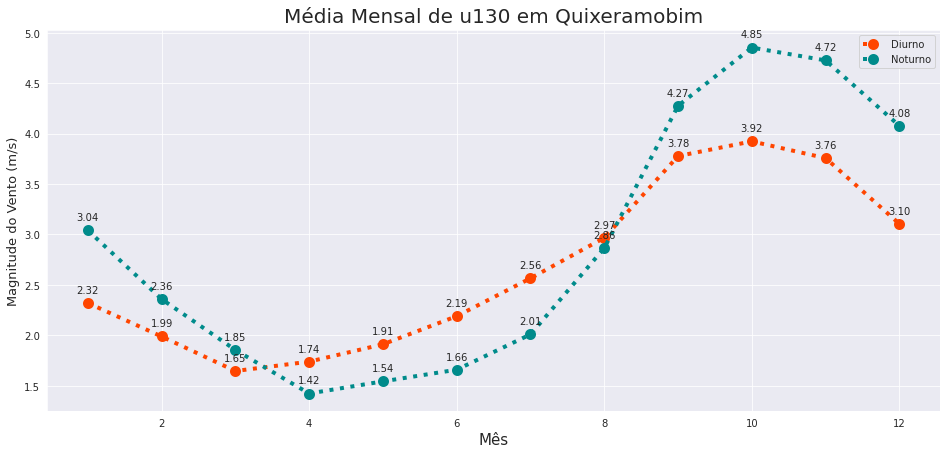

In [124]:
plot_line2('Quixeramobim')


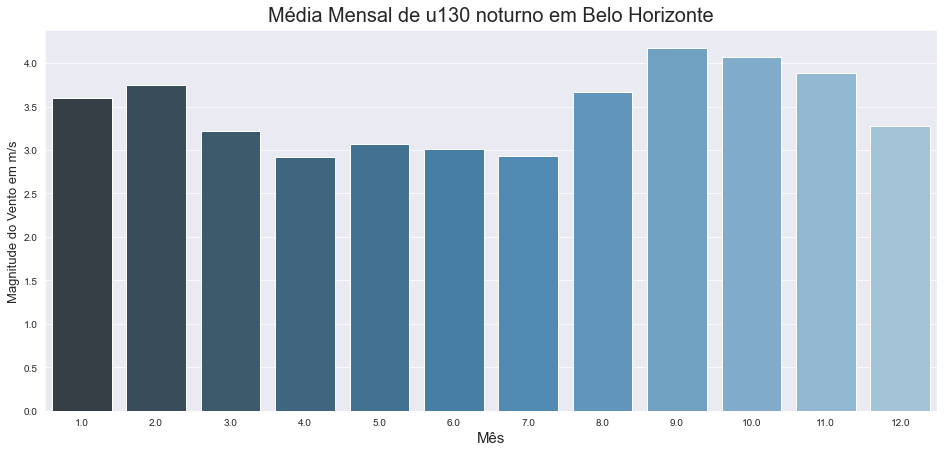

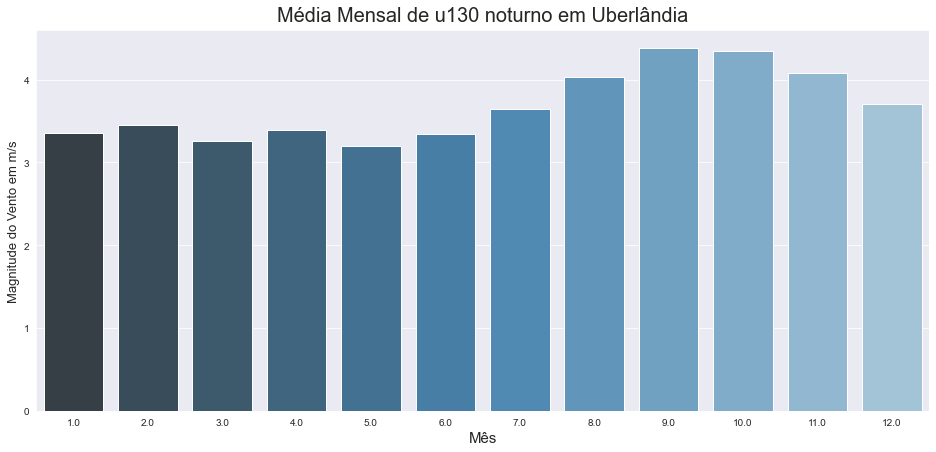

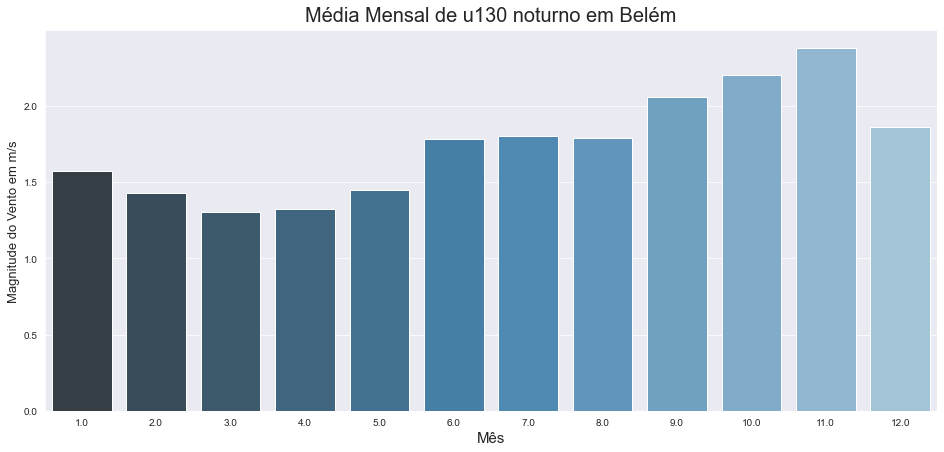

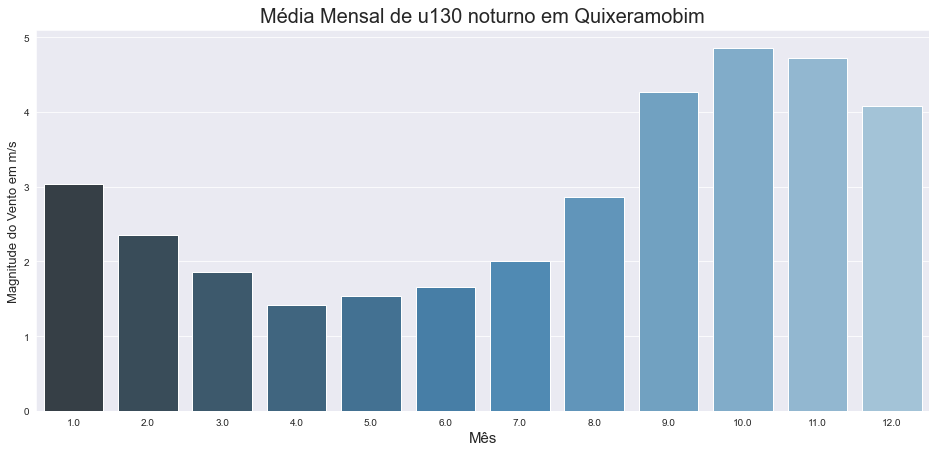

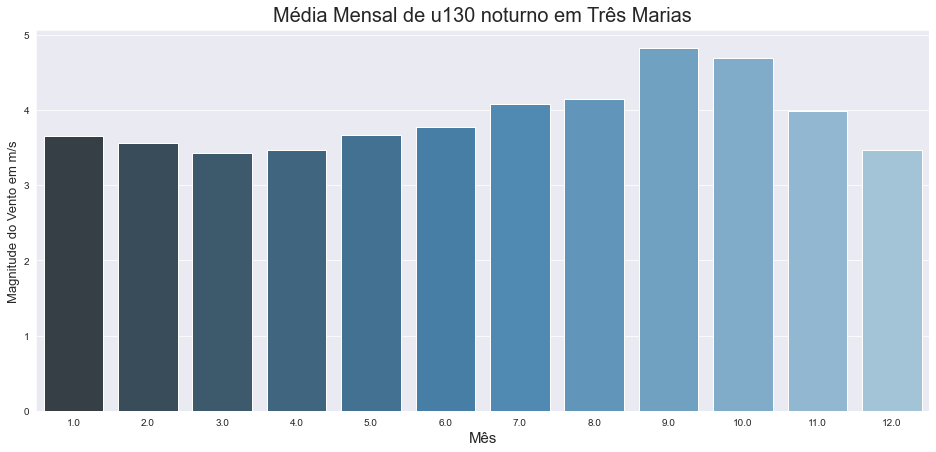

In [164]:
for cada in df_list:
    plot_bar(cada, 'noturno')